# IOT Authentication


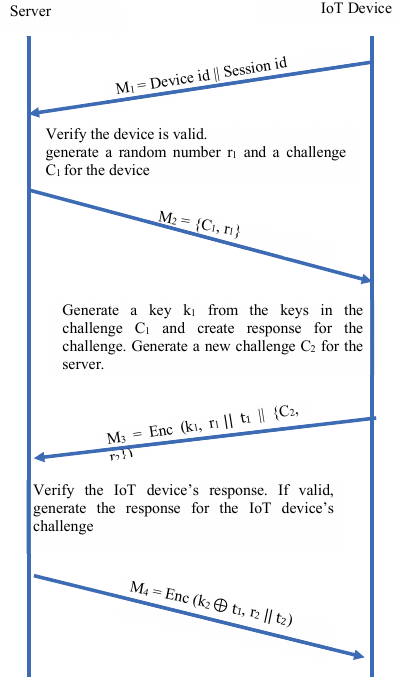

In this work we will implement in a simulated system a 3 way authentication protocol between a server and a IOT device. We will use python feature to work also as a object oriented language defining a server and a IOT class with the definition of the functions used to validate and send the messages to the other entity.

First of all we assume that the IOT devices has stored a secure vault in an encrypted format and that also the server knows it and it is stored in a secure DB. The secure vault contains n keys each of length m bytes. In this case these parameters are global variables and can be easility set. In a real scenario we could have hardware restriction in the IOT device but in this case we can set up these values as our will ( more or less since the key length is correlated to others operations such as the use of the encryption algorithm AES and the xor operations. So changing it could cause some errors in the further operations)

Executing the simualtion could happens that we generate an AES key that is not of the proper size causing the program to crash. This is due to the fact that converting hex in int in order to perform XOR we could loose some information, decreasing the key size from the initial length to a lower one. To solve this issue has been implement a mechanism in the XOR function that allows to mantain the xored hexadecimal strings of the same size in order to not loose information and not causing the error explained above.

In [ ]:
#Just change the print color for the exceptions
import importlib.util
if importlib.util.find_spec("colorama") is None:
    !pip install colorama

In [ ]:
import random
import secrets
import pickle
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import padding
import os
import re
import operator
import hmac
import hashlib
import sys

from colorama import init, Fore, Back, Style

In [ ]:
m = 16 # Keys length in bytes **BETTER TO NOT CHANGE IT**
n = 1024 # Number of keys inside the secure vault **CAN BE CHANGED BUT NOT TO A SMALL VALUE**
T_SIZE = 32 # Constant value used in the protocol to generate random numbers of that size in bits **NO NEED TO CHANGE IT**
Iot_device_UID = secrets.token_hex(32) #Randomly generate the device UID, that is shared with the server at initialization time

Here we define to global function that will be used in order to encrypt and the decrypt the messages exchanged between the IOT device and the server.
In this case we use AES as encryption algorithm since is the one proposed by the paper authors and is suitable also in a real case scneario where IOT devices does not have great performances.

In [ ]:
def aes_encrypt(key, plaintext):
    # Serialize the list, since we pass to this function the secure vault itself, represented as a list
    serialized_plaintext = pickle.dumps(plaintext)
    #Encode the key from type str to byte representation
    key = key.encode()
    plaintext = plaintext.encode()
    # Generate a random initialization vector
    iv = os.urandom(16)
    # Create an AES cipher object
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())

    # Encrypt the serialized plaintext
    encryptor = cipher.encryptor()
    padder = padding.PKCS7(algorithms.AES.block_size).padder()
    padded_data = padder.update(serialized_plaintext) + padder.finalize()
    ciphertext = encryptor.update(padded_data) + encryptor.finalize()

    return iv + ciphertext

def aes_decrypt(key, ciphertext):
    # Extract the initialization vector from the ciphertext
    iv = ciphertext[:16]
    ciphertext = ciphertext[16:]
    #encode the key
    key=key.encode()
    # Create an AES cipher object
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())

    # Decrypt the ciphertext
    decryptor = cipher.decryptor()
    decrypted_data = decryptor.update(ciphertext) + decryptor.finalize()
    unpadder = padding.PKCS7(algorithms.AES.block_size).unpadder()
    unpadded_data = unpadder.update(decrypted_data) + unpadder.finalize()

    # Deserialize the plaintext
    plaintext = pickle.loads(unpadded_data)

    return plaintext

In this block we define 3 others global utility functions;

- **secure_vault_initialization(n,m)** is used to randomly initialize the secure_vault with n keys of m bytes size using their the hexadecimal representation.

- **xor_hex(hex_str1, hex_str2)** is used to perform XOR between 2 hexadecimal string that are converted to their int representation and the reconverted again to the hex representation since the keys are genereated and used in hexadecimal format. Zeros are padded to the right of the 2 inputs variables and the result if needed, in this way we obtain a coerent result with the inital length of the hexadecimal strings and not loose information performing the XOR and converting from hex to int and viceversa.

- **challenge_generation(secure_vault)** is used to generate the challenge C1 and C2. It randomly generatea a number p that must be less than the length of the vault and is used to take all the numbers below that p and adding them in a list, each of these numbers represent an index of a key stored in the secure vault. Therefore the challenge consist of a set of p indexes of the secure vault. When this function will be called to generate C2, there will be a check for which the length of C1 and C2 should be different in order to prevent the generation of two challenges of the same length

In [ ]:
def secure_vault_initialization(n,m):

  secure_vault = list()
  for i in  range(n):
    tmp = secrets.token_hex(m)
    secure_vault.append(tmp)
  print("Secure vault:",str(secure_vault))
  return secure_vault


def xor_hex(hex_str1, hex_str2):

    max_length = max(len(hex_str1), len(hex_str2)) #Compute the max string between the hex_str1 and hex_str2
    hex_str1 = hex_str1.ljust(max_length, '0')  # Pad with zeros to the right if needed
    hex_str2 = hex_str2.ljust(max_length, '0')  # Pad with zeros to the right if needed

    # Convert hexadecimal strings to integers
    int_val1 = int(hex_str1, 16)
    int_val2 = int(hex_str2, 16)


    result_int = int_val1 ^ int_val2 # Perform the XOR


    hex_result = hex(result_int)[2:].zfill(max_length)  # Convert the result back to hexadecimal string

    return hex_result

def challenge_generation(secure_vault):
    C = list()
    p = random.randint(5,len(secure_vault)) #p will be set to be the length of the challenge, it it set to be greater than 5 in order to not have a too short challenge.
    for i in range(p):
      C.append(i)
    return C



IOT device class

- **send_req_message(self):** Iot device starts the authentication protocol by sending in clear to the server his UID and the randmly generated session_ID: $$ M1=(deviceUID,sessionID)$$
- **challenge_response(self,M2)**: Receive the message M2 containing the challenge C1 and r1 from the server (i.e. M2{C1,r1}). Generate the challenge C2 by collecting the secure vault indexes up to p(that must be random and less than n). Generates 2 random numbers t2 and r2 and finally build up the message M3 to send to the server encrypting it using k1 as key(obtained by xoring the secure vault elements which indexes are contained in C1)$$ k1 = P[C_{11}] \oplus P[C_{12}] \oplus ... \oplus P[C_{1p}] $$

   $$ M3 = ENC(k1, r1||t1||\{C2,r2\}) $$

- **verify_server(self, M4):** Receive the message M4 and authenticate the server by getting back r2 from the message by using: $$ k2 \oplus t1 $$
Then, generate the session key: $$ t = t1 \oplus t2 $$
that will be used to encrypt the future communications.


In [ ]:
class IOT_device:

  #Initialize the IOT_device using a constant UID that is already shared with the server,
  def __init__(self):
    self.UID = Iot_device_UID
    self.session_ID = secrets.token_hex(16) #
    self.secure_vault = secure_vault_initialization(n,m)


  #First step of the 3 way authentication mechanism, concatenate the UID and the session_ID and send it to the server
  def send_req_message(self):
    return self.UID+self.session_ID

  #Receive the message M2 from the server extract C1 and build C2, generate k1, t1 and r2. Finally encrypt
  def challenge_response(self,M2):
    self.M2 = M2
    #Extract C1 and r1 from the message M2
    C1 = M2[0]
    r1 = M2[1]
    k1 = xor_hex(self.secure_vault[C1[0]],self.secure_vault[C1[1]]) #Generate k1 by performing XOR on the secure vault elements which indexes are contained in C1
    for i in range(2,len(C1)):
      k1 = xor_hex(k1,str(self.secure_vault[C1[i]]))

    t1 = secrets.randbits(T_SIZE) #Generate a random number of T_SIZE bits

    #Save t1 and k1 in the IOT device class
    self.t1 = t1
    self.k1 = k1

    r2 = secrets.token_hex(T_SIZE) # Randomly generate r2

    C2 = challenge_generation(self.secure_vault) #Generate the challenge to send to the server

    #C2 must not have the same length of C1 otherwise an attacker can get the key used for C1 and reuse it for C2
    #Larger the parameter n is lower are the probability for which C1 and C2 are the same.
    while (len(C2)==len(C1)):
      C2 = challenge_generation(self.secure_vault)

    #Save C2 and r2 in the IOT device class
    self.C2 = C2
    self.r2 = r2

    second_part = list()

    #Append C2 and r2 as 2 different elements of the list
    second_part.append(C2)
    second_part.append(r2)

    message = str(r1)+str(t1)+str(second_part) #Concatenate: r1||t1||{C2,r2}

    try:
      # Save M3 in the device class and send it to the server
      M3 = aes_encrypt(k1, message) #Encrypt r1||t1||{C2,r2} using k1 as key
      self.M3 = M3
    except:
      print(Fore.RED+"Something went wrong with the encryption mechanism, retry!!")
      sys.exit()
    return M3



  #Function used to perform the last step, decrypt M4 in order to retrieve r2
  def verify_server(self, M4):
    self.M4 = M4
    #Compute k2 using xoring the secure vault indexes contained in C2
    k2 = xor_hex(self.secure_vault[self.C2[0]],self.secure_vault[self.C2[1]])
    for i in range(2,len(self.C2)):
      k2 = xor_hex(k2,self.secure_vault[self.C2[i]])
    #Retrieve the key to decrypt by xoring k2 and t1
    key = xor_hex(k2,str(self.t1))
    try:
      clear_text = aes_decrypt(key,M4)
    except:
      print(Fore.RED+"Something went wrong with the decryption mechanism, retry!")
      sys.exit()
    #Retrieve t2 from the cleartext
    tmp = clear_text.find(self.r2)
    if(tmp!=-1):
      t2 = clear_text[tmp + len(self.r2):]


      t = self.t1^int(t2) #Compute session key for further secure communication
      self.t = t

      return ("Device correctly authenticated!")
    else:
      return ("Message has been compromised")


  #Call it in order to update the secure vault
  def update_secure_vault(self):

    key = str(self.M2)+str(self.M3)+str(self.M4) #Concatenate the exchanged messages up to know to generate the key

    #Concatenate each key of the secure vault in order to create a unique single string
    secure_vault_concat = self.secure_vault[0]+self.secure_vault[1]
    for i in range(2,len(self.secure_vault)):
      secure_vault_concat = secure_vault_concat+self.secure_vault[i]


    #h = hmac.new(key.encode('utf-8'), pickle.dumps(secure_vault_concat), hashlib.md5)  #Generate the HMAC of the current secure vault using the exchanged messages as a key

    #Generate the HMAC of the current secure vault using the exchanged messages as a key and SHA1 as digest algorithm
    h = hmac.new(key.encode('utf-8'), pickle.dumps(secure_vault_concat), hashlib.sha1)
    k = len(h.hexdigest()) #Length in bytes of the generated hash

    total_bits = len(secure_vault_concat) #Total length of the concatenation of the secure vault content

    # Compute the number of bits to pad at the end if total_bits is not exactly divisible for k
    if((total_bits % k)!=0):
      padding_bits = (k - (total_bits % k)) % k
      secure_vault_concat += "0" * padding_bits  # Concatenate the string with necessary padding

    j = total_bits//k #Take j partitions from the secure vault each of length k

    updated_secure_vault = list() #New list used to store the new secure vault values
    #Take j partitions with length k bits performing XOR with (h XOR i)
    # where i is the index of the partion. In this way we can update the secure vault with new keys

    for i in range(j):
        start_index = i * k
        end_index = start_index + (k)
        bits = secure_vault_concat[start_index:end_index]
        h_XOR_i = xor_hex(h.hexdigest(),hex(i)) #xor the hexadecimal representation of the hash with the current index i
        updated_secure_vault.append(xor_hex(bits,h_XOR_i)) # xor the taken k bits with h_XOR_i and add the result in the new secure vault

    return updated_secure_vault

# Server class

- **generate_challenge1(self,first_Message)**: Check the device UID and then generate the challenge C1 collecting the secure vault indexes up to p(that must be random and less than n). Then it generates a random number r1, add C1 and r1 as elements of the list M2 (i.e. the message to send to the IOT device): $$ M2  (C1,r1) $$

- **resolve_challenge(self,M3)** Receive M3 form the IOT device, decrypt the message and retrieve the content: $$ r1||t1||({C2,r2}) $$ Split each of these values in the appropriate way and then compute  the last message to send to the IOT device:
$$ M4 = Enc (k2 \oplus t1, r2||t2) $$ Where k2 is given by: $$ k2 = P[C_{21}] \oplus P[C_{22}] \oplus ... \oplus P[C_{2p}] $$ and each P is a key of the secure vault given by the indexes collected in C1. Finally we can compute :
$$ key = k2 \oplus t1 $$

In [ ]:
class server:

  #Initialize the server with the Iot device UID and the secure vault
  def __init__(self,secure_vault):
    self.device_UID = Iot_device_UID
    self.secure_vault = secure_vault


  def generate_challenge1(self,first_Message):

    #Check if the server has the same device_UID
    if(first_Message.find(self.device_UID)!=-1):
      r1 = secrets.token_hex(T_SIZE) ## r1 must be random
      C1 = challenge_generation(self.secure_vault)  # C1 is a set of p distinct numbers , and each number represents an index of a key stored in the secure vault

      #Set C1 and r1 as global variable for the class server
      self.C1 = C1
      self.r1 = r1

      #Build M1 as a list and send it back to the device. The first element always contains the challenge C1 and the second element is the random number r1
      M1 = list()
      M1.append(C1)
      M1.append(r1)
      return M1

    else:
      print(Fore.RED+"Error! The server does not recognize the device UID")

  #Receive M3, decrypt it and retrieve the fields
  def resolve_challenge(self,M3):
    #First of all server need to retrieve the key(k1) by performing the same
    # operations as the IOT device on the secure vault
    k1 = xor_hex(self.secure_vault[self.C1[0]],self.secure_vault[self.C1[1]])

    for i in range(2,len(self.C1)):
      k1 = xor_hex(k1,self.secure_vault[self.C1[i]])
    try:
      clear_text = aes_decrypt(k1,M3) #Decrypt M3 using k1 as key
    except:
      print(Fore.RED+"Something went wrong with the decryption mechanism, retry!!")
      sys.exit()

    #Check if r1 has not been changed after it has been sent the first time by the server itself
    if(clear_text.find(self.r1) !=-1):

      #We need to extact r1,t1 and {c2,r2} from the clear text.
      # They has been concatenated in this order:r1||t1||{C2,r2}
      #In order to do so we can use regular expression since we know the way in which they has been concatenated and which are the delimiters

      pattern1 = self.r1  # Extracts r1

      #Pattern to extract t1, that is between r1 and {C2,r2} (ending with the characters"[[")
      pattern2 = re.compile(self.r1 + r'(.*?)\[\[', re.DOTALL)

      ##Pattern to extract {C2,r2}, since it is a list that in the first position contains another list(i.e C2) and in the second position a number (i.e r2) such as [['',''],'']
      pattern3 = '\[\[.*?\'\]'
      match1 = re.search(pattern1, clear_text)
      match2 = re.search(pattern2, clear_text)
      match3 = re.search(pattern3, clear_text)
      r1= ""
      t1 = ""
      second_part = list()

      #Retrieve r1
      if match1:
        r1 = match1.group(0)

      #Retrieve t1
      if match2:
        t1 = match2.group(1)

      #Retrieve {C2,r2} and put these value into a list of 2 elements which has as first element another list
      if match3:
        substring3 = match3.group()
        second_part = eval(substring3)
    #If the code follow this path it means the originally generated r1 has been modified and probably an attack or an error is occuring.
    else:
      print("Message has been compromised!")
      sys.exit()


    M4 = self.generate_response(t1,second_part)

    t = int(t1)^self.t2 #Generate t for further secure communication with the device
    return M4

  #Generate the encrypted message M4 to send to the IOT device class
  def generate_response(self, t1, second_part):

    #Obtain C2 and r1 knowing that these are the first and the second element of the list second_part
    C2 = second_part[0]
    r2 = second_part[1]

    #Compute the key to used to decrypt the message
    k2 = xor_hex(self.secure_vault[C2[0]],self.secure_vault[C2[1]])
    for i in range (2,len(C2)):
      k2 = xor_hex(k2,self.secure_vault[C2[i]])
    k2 = xor_hex(k2,t1)


    t2 = secrets.randbits(T_SIZE) #Randomly generate r2
    self.t2 = t2 #Save t2 in the server class
    clear_message = str(r2)+str(t2) #Concatenate r2 and t2
    try:
      M4 = aes_encrypt(k2,clear_message) #Encrypt the messagge using k2 as key
    except:
      print(Fore.RED+"Something went wrong with the encryption mechanism, retry!!")
      sys.exit()

    return M4


# Secure vault update:

When the two devices has been authenticated each other we can change the secure vault by using HMAC on the current state of the secure vault (i.e h) and as key of HMAC we use the exchanged messages history producing k bits at output. In particular we divide the current value of the secure vault is divided in partitions each having a size of k bits. Then we XOR eahc of these partition with the value h in order to generate the new secure vault content.

In [ ]:
def update_secure_vault(M1, M2, M3, M4, secure_vault):

    key = str(M1)+str(M2)+str(M3)+str(M4) #Concatenate the exchanged messages up to now

    #Concatenate each key of the secure vault in order to create a unique single string
    secure_vault_concat = secure_vault[0]+secure_vault[1]
    for i in range(2,len(secure_vault)):
      secure_vault_concat = secure_vault_concat+secure_vault[i]


    h = hmac.new(key.encode('utf-8'), pickle.dumps(secure_vault_concat), hashlib.sha1) #Generate the HMAC of the current secure vault using the exchanged messages as a key and SHA1 as digest algorithm

    k = len(h.hexdigest()) #Length in bytes of the generated hmac hash, the new generated keys will have this length if >= of the original secure vault key. Using sha1 we generate keys with a length of 40 bytes

    total_bits = len(secure_vault_concat) #Total length of the concatenation of the secure vault content

    # Compute the number of bits to pad at the end if total_bits is not exactly divisible for k
    if((total_bits % k)!=0):
      padding_bits = (k - (total_bits % k)) % k
      secure_vault_concat += "0" * padding_bits  # Concatenate the string with necessary padding

    j = total_bits//k #Take j partitions from the secure vault each of length k
    updated_secure_vault = list() #New list used to store the new secure vault values
    #Take j partitions with length k bits performing XOR with (h XOR i)
    # where i is the index of the partion. In this way we can update the secure vault with new keys

    for i in range(j):
        start_index = i * k
        end_index = start_index + (k)
        bits = secure_vault_concat[start_index:end_index]
        h_XOR_i = xor_hex(h.hexdigest(),hex(i)) #xor the hexadecimal representation of the hash with the current index i
        updated_secure_vault.append(xor_hex(bits,h_XOR_i)) # xor the taken k bits with h_XOR_i and add the result in the new secure vault

    return updated_secure_vault

In [ ]:
#Start the 3-way authentication protocol on the already initialized IOT device and server
def three_way_auth(device,server):
  #Device sends the UID and the Session ID to the server
  #UID,session_ID = device.send_req_message()
  M1 = device.send_req_message()
  print("\nM1:",str(M1))

  # Server checks the session_ID validity and generate the challenge 1
  # to send to the device
  M2 = server.generate_challenge1(M1)

  print("\nM2:",str(M2))
  M3 = device.challenge_response(M2)
  print("\nM3(encrypted):",str(M3))

  M4 = server.resolve_challenge(M3)

  print("\nM4(encrypted):",str(M4))

  clear_text = device.verify_server(M4)

  print("\n",str(clear_text))

  #Update secure vault on the device
  updated_secure_vault_device = update_secure_vault(M1, M2, M3, M4, device.secure_vault)
  print("\nIOT device: Updated secure vault: "+str(updated_secure_vault_device))

  #Update secure vault on the server
  updated_secure_vault_server = update_secure_vault(M1, M2, M3, M4, server.secure_vault)
  print("\nServer: Updated secure vault: "+str(updated_secure_vault_server))






In [ ]:
## Initialize the device and the server
device = IOT_device()
server = server(device.secure_vault)

#Perform the 3 way authentication protocol
three_way_auth(device,server)




Secure vault: ['eafa9737c18d4d1b48a1920e0afb5f99', '3757bede6008ed8266dfb2fe0e466865', 'e62fe1dcfa53d8acfbdd28fe7c033045', 'ac6395fc943f401e7e3c878e39316dfb', 'ed15d7e8b72c98d7c9cd2d4aee95345f', 'a6b6c9d6eec3cf05f735e6f3fec050e8', '8d1a97233e37d8e2bf82de295525fa09', 'c11d2792169abae596a99953e8d25e58', '435cc5e4b2da3169d36117238e23322b', '76c786fe981491bcff7a033fcc0c6155', 'f95eef180182f13884be49331acb2da7', 'd7dd13921da35ba8bf6969d5b00767d1', 'b25b3db4d9ac4ab1f99f1f87cd9bbe91', 'd36fc09ba2f91215bc06b0b512fa0e99', 'a7cb8b69622942b60cb72ff9f0c290ff', '3f666c359affe1d8c305d46ada489690', '118b0c5f7aceaea07488278b170028b2', '73363df1e10ec8eb11b6089ee457e44e', '84f7b160d48a6165aec08735f637bcff', '7bf16c0071c9db457ffc3b658e234d90', '206b8565c0b219b345571aee589d9971', '4e3a5ff5162ea65e93679fdb2a945f1b', 'e7e96df86d8950d97f54c3e7ab40ad41', 'ba7efc5144fd268e0c25c8b9a48e6835', '450230adb50e2425da7e0021826cdaca', 'a79ea3a006e73bdc4695cee576927607', 'b230cb0f427a87a13380c7b03e95eb0a', '6c4c0684976f

# Final Results and conclusions

- **Man in the middle Attack:**

  An attacker can sniff all the traffic between the two devices obtaining the exchanged messages and then want to authenticate itself as a server to the IOT device and as IOT device to the server.
  However this is not possible since after the authentication the IOT device and the server uses a session key named t to authenticate all the exchanged messages. t is obtained by xoring t1 and t2, 2 separate random numbers exhcanged in encrypted form. So an attacker to obtain t1 and t2 should know the key for dectypting the messages but it is part of the secure vault that is kept secret by both the entities.

- **Next password prediction:**

  The IoT devices and the server exchange data and update the secure vault values after each successful session, hence security is maintained by ensuring that each new vault value is random with respect to the previous value. This prevents adversaries from predicting subsequent vault values, even if they manage to retrieve some passwords from the current vault. Moreover, when creating a new vault, the previous vault value is hashed using HMAC with exchanged data as the key, and a random value is generated by the random oracle. This random value is then XORed with the previous vault values, ensuring that the resulting new vault values are random and unpredictable to attackers.


- **Side channel attacks:**

  There is no possibility for an attacker by performing a side channel attacks to retrieve the secure vault keys by knowing the AES encryption key since the encryption key itself is a combination of XOR between the secure vault keys.

---
# Conclusion

The protocol works as expected since we are able to exchange and retrieve back the content of the encrypted messages authenticating both the entities, moreover both the device and the server are able to update the secure vault by their own using the exchanged messages up to that moment and in this way securing the future communications. However we need to considered that we are in a simulated environment where we have huge computational power and no restrain on memory and network capabilities. In a real scenario the entire protocol should work in a different way and many things can go wrong. Surely if we decide to implement the protocol in real devices we should care of many other aspect that has not be considered in this simulation.
